In [39]:
# General Library
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

#Pipline line library
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import category_encoders as ce


#Machine Learning Library
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

import catboost as cb
import lightgbm as lgbm

#Evaluation Metrix and Hyperparameter tuning
from sklearn.metrics import accuracy_score,f1_score,plot_confusion_matrix,recall_score,precision_score

#Model saving
import joblib

import warnings
warnings.filterwarnings("ignore")

In [40]:
df=pd.read_csv("train_MpHjUjU.csv",skipinitialspace=True,dayfirst=True, parse_dates=['Dateofjoining','MMM-YY','LastWorkingDate'])
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1


### Devided data in train and test based on timeline

In [41]:
train=df[df['MMM-YY']<='2016-12-31']
test=df[(df['MMM-YY']>'2016-12-31') & (df['MMM-YY']<='2017-07-31')]

### Creat new varibale as per EDA observation last month Average rating and Business value

In [42]:
Emp_id=df['Emp_ID'].unique().tolist()


def Last_3_M_Rat(df):
    Emp_id=df['Emp_ID'].unique().tolist()
    Last_3_M_Rating={}
    for i in Emp_id: 
        a=df[(df['Emp_ID']==i)]
        b=a[a['MMM-YY']>=a['MMM-YY'].max()-dt.timedelta(days=60)]['Quarterly Rating'].mean()
        Last_3_M_Rating[i]=int(b)
    return Last_3_M_Rating


def Last_3_M_Busi(df):
    Emp_id=df['Emp_ID'].unique().tolist()
    Last_3_M_Business={}
    for i in Emp_id: 
        a=df[(df['Emp_ID']==i)]
        b=a[a['MMM-YY']>=a['MMM-YY'].max()-dt.timedelta(days=60)]['Total Business Value'].mean()
        Last_3_M_Business[i]=int(b)
    return Last_3_M_Business

In [43]:
Train_3_M_Rating =Last_3_M_Rat(train)
Train_3_M_Business= Last_3_M_Busi(train)


Test_3_M_Rating =Last_3_M_Rat(test)
Test_3_M_Business= Last_3_M_Busi(test)


### Grouping employee detail to unique employee recored againts each employee

In [44]:
index_col=["Emp_ID",'Gender','City','Education_Level','Dateofjoining']
df_train=train.groupby(index_col).agg({'Age':'min',
                            'MMM-YY':'max',        
                           'Salary':['min','max'],
                           'LastWorkingDate':'max',
                           'Joining Designation':"min",
                          'Designation':'min',
                          'Total Business Value':['mean'],
                        'Quarterly Rating':['min','max','mean']}).reset_index()




df_test=test.groupby(index_col).agg({'Age':'min',
                            'MMM-YY':'max'  ,      
                           'Salary':['min','max'],
                           'LastWorkingDate':'max',
                           'Joining Designation':"min",
                          'Designation':'min',
                          'Total Business Value':['mean'],
                        'Quarterly Rating':['min','max','mean']}).reset_index()

In [45]:
df_train.columns = ['_'.join(col) for col in df_train.columns]
df_test.columns = ['_'.join(col) for col in df_test.columns]

### Define Target Varibale

In [46]:
train_target=df[(df['MMM-YY']>'2016-12-31') & (df['MMM-YY']<='2017-07-31')].groupby('Emp_ID').agg({'LastWorkingDate':'max'}).reset_index()

test_target=df[(df['MMM-YY']>'2017-07-31')].groupby('Emp_ID').agg({'LastWorkingDate':'max'}).reset_index()

In [47]:
train_target['Target']=train_target['LastWorkingDate'].apply(lambda x : 0 if x is pd.NaT else 1 )
test_target['Target']=test_target['LastWorkingDate'].apply(lambda x : 0 if x is pd.NaT else 1 )

In [48]:
df_train=df_train.merge(train_target,left_on='Emp_ID_',right_on='Emp_ID',how='left')
df_test=df_test.merge(test_target,left_on='Emp_ID_',right_on='Emp_ID',how='left')

#### Create new feature based on EDA

In [49]:
df_train['LastWorkingDate_max'].replace(pd.NaT,dt.datetime(2018,1,1),inplace=True)
df_train["Employee_Vintage"]=((df_train['LastWorkingDate_max']-df_train['Dateofjoining_'])/np.timedelta64(1,"M")).astype('int')
df_train["Last_3_M_Rating"]=df_train['Emp_ID_'].map(Train_3_M_Rating)
df_train['Last_3_M_Business']=df_train['Emp_ID_'].map(Train_3_M_Business)
df_train['week']=df_train["Dateofjoining_"].dt.week


df_test['LastWorkingDate_max'].replace(pd.NaT,dt.datetime(2018,1,1),inplace=True)
df_test["Employee_Vintage"]=((df_test['LastWorkingDate_max']-df_test['Dateofjoining_'])/np.timedelta64(1,"M")).astype('int')
df_test["Last_3_M_Rating"]=df_test['Emp_ID_'].map(Test_3_M_Rating)
df_test['Last_3_M_Business']=df_test['Emp_ID_'].map(Test_3_M_Business)
df_test['week']=df_train["Dateofjoining_"].dt.week

#### Filter unwanted columns 

In [50]:
df_train.drop(['Emp_ID_',"MMM-YY_max",'Dateofjoining_','Emp_ID','Education_Level_','Last_3_M_Business','LastWorkingDate','Joining Designation_min','Salary_min','Total Business Value_mean','Quarterly Rating_mean','LastWorkingDate_max','Quarterly Rating_min','Quarterly Rating_max'],axis=1,inplace=True)
df_train.fillna(1,inplace=True)
df_train.rename(columns={"Gender_":"Gender","City_":"City","Age_min":"Age","Salary_max":"Salary",'Designation_min':"Designation"},inplace=True)
df_train.head()

,Gender,City,Age,Salary,Designation,Target,Employee_Vintage,Last_3_M_Rating,week
0,Male,C23,28,57387,1,1.0,2,2,52
1,Male,C13,43,65603,2,1.0,12,1,49
2,Male,C9,29,46368,1,1.0,1,1,1
3,Male,C23,35,28116,1,1.0,5,1,26
4,Male,C19,29,119227,4,0.0,67,1,22


In [51]:
df_test.drop(['Emp_ID_',"MMM-YY_max",'Dateofjoining_','Emp_ID','Education_Level_','LastWorkingDate','Joining Designation_min','Last_3_M_Business','Salary_min','Total Business Value_mean','Quarterly Rating_mean','LastWorkingDate_max','Quarterly Rating_min','Quarterly Rating_max'],axis=1,inplace=True)
df_test.fillna(1,inplace=True)
df_test.rename(columns={"Gender_":"Gender","City_":"City","Age_min":"Age","Salary_max":"Salary","Designation_min":"Designation"},inplace=True)
df_test.head() 

,Gender,City,Age,Salary,Designation,Target,Employee_Vintage,Last_3_M_Rating,week
0,Male,C13,43,65603,2,1.0,4,1,52
1,Male,C19,30,119227,4,1.0,67,1,49
2,Female,C19,26,40342,3,1.0,4,1,1
3,Female,C29,34,22755,1,1.0,21,1,26
4,Male,C10,41,31224,1,1.0,23,1,22


In [52]:
x_train=df_train.drop('Target',axis=1)
y_train=df_train.Target

x_test=df_test.drop('Target',axis=1)
y_test=df_test.Target

In [53]:
#Create Pipeline

onhot=OneHotEncoder(drop ="if_binary")
target_en=ce.TargetEncoder()
Freq_en=ce.CountEncoder(normalize=True,min_group_size={"City":0})
sc=StandardScaler()

#column traansformer
CT=make_column_transformer((onhot,["Gender"]),
                           (target_en,["City"]),
                            remainder='passthrough')

In [54]:
# Define Function for train model

Model_Summary=pd.DataFrame(columns=['Model','Train_F1_Score','Test_F1_Score','Precision','Recall'])

def Training(model):
    global Model_Summary
    pip=make_pipeline(CT,sc,model)
    pip.fit(x_train,y_train)
    y_pre=pip.predict(x_test)
    
    
    Train_F1_Score=f1_score(y_train, pip.predict(x_train))
    Test_F1_Score=f1_score(y_test, y_pre)
    Precision = precision_score(y_test, y_pre)
    Recall=recall_score(y_test,y_pre)
                                
    print(f"Train F1_Score : {Train_F1_Score}")
    print(f"Test F1_Score : {Test_F1_Score}")
    print(f"Precision : {Precision}")
    print(f"Recall : {Recall}")
    print(f" consufion matrix : {plot_confusion_matrix(pip,x_test,y_test)}")
    
    Model_Summary=Model_Summary.append({"Model":model,"Train_F1_Score":Train_F1_Score,"Test_F1_Score":Test_F1_Score,
                                    "Precision":Precision, "Recall":Recall},ignore_index=True)

### Logistic Regression

Train F1_Score : 0.8954220915581688
Test F1_Score : 0.8285714285714285
Precision : 0.7483870967741936
Recall : 0.928
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000023348899760>


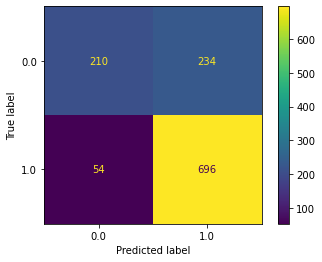

In [55]:
Logistic=LogisticRegression(class_weight='balance')

Training(Logistic)

### Random Forest

Train F1_Score : 1.0
Test F1_Score : 0.8315412186379929
Precision : 0.7532467532467533
Recall : 0.928
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000023306626190>


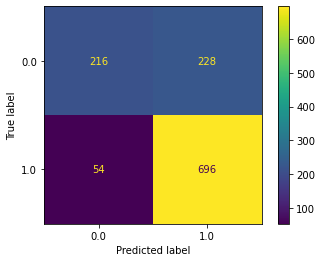

In [56]:
rf=RandomForestClassifier(random_state=12,class_weight={0:2,1:1})
Training(rf)

###  Adboost

Train F1_Score : 0.9067796610169492
Test F1_Score : 0.8352306770521271
Precision : 0.7584330794341676
Recall : 0.9293333333333333
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x00000233605221C0>


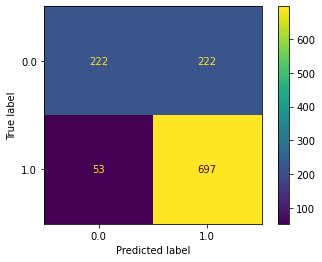

In [57]:
ad=AdaBoostClassifier(random_state=123,)

Training(ad)

### KNeighbors

Train F1_Score : 0.9170565716716291
Test F1_Score : 0.8245294474802671
Precision : 0.7569676700111483
Recall : 0.9053333333333333
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000023360567280>


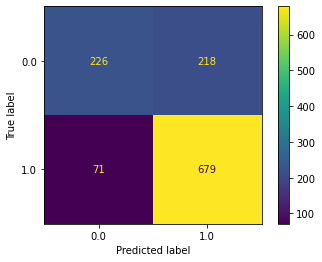

In [58]:
knn=KNeighborsClassifier(n_neighbors=5)

Training(knn)

### Support vector Machine

Train F1_Score : 0.9080659150043364
Test F1_Score : 0.8424999999999999
Precision : 0.7929411764705883
Recall : 0.8986666666666666
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x00000233605EC6A0>


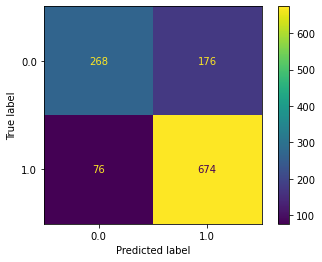

In [59]:
svc=SVC(class_weight={0:1.5,1:0.8})
Training(svc)

### XGboost

Train F1_Score : 0.9978251413658111
Test F1_Score : 0.8332344213649852
Precision : 0.7508021390374332
Recall : 0.936
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002334D6ED190>


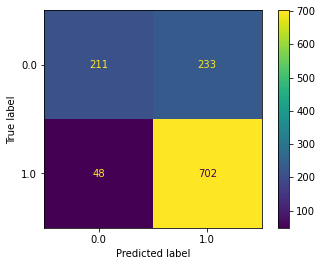

In [60]:
xg=xgb.XGBClassifier(random_state=10,scale_pos_weight=2.8)

Training(xg)

#### GaussianNB

Train F1_Score : 0.8772389689820881
Test F1_Score : 0.8267326732673268
Precision : 0.7713625866050808
Recall : 0.8906666666666667
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002334D7D5E50>


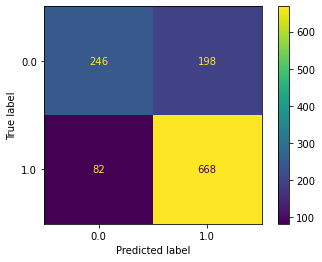

In [61]:
gus=GaussianNB()

Training(gus)

### catboost

Learning rate set to 0.012443
0:	learn: 0.6792926	total: 18.3ms	remaining: 18.3s
1:	learn: 0.6709560	total: 20.6ms	remaining: 10.3s
2:	learn: 0.6628497	total: 22.7ms	remaining: 7.55s
3:	learn: 0.6540823	total: 24.8ms	remaining: 6.18s
4:	learn: 0.6429799	total: 27.1ms	remaining: 5.39s
5:	learn: 0.6350473	total: 29.2ms	remaining: 4.84s
6:	learn: 0.6215277	total: 31.6ms	remaining: 4.48s
7:	learn: 0.6146379	total: 33.7ms	remaining: 4.17s
8:	learn: 0.6034765	total: 35.8ms	remaining: 3.94s
9:	learn: 0.5969646	total: 38ms	remaining: 3.77s
10:	learn: 0.5865543	total: 40.2ms	remaining: 3.62s
11:	learn: 0.5810054	total: 41.6ms	remaining: 3.42s
12:	learn: 0.5724248	total: 43.8ms	remaining: 3.33s
13:	learn: 0.5630982	total: 45.9ms	remaining: 3.23s
14:	learn: 0.5577464	total: 48.1ms	remaining: 3.16s
15:	learn: 0.5475732	total: 50.3ms	remaining: 3.1s
16:	learn: 0.5423961	total: 52.7ms	remaining: 3.05s
17:	learn: 0.5330396	total: 54.9ms	remaining: 3s
18:	learn: 0.5286680	total: 56.9ms	remaining: 2.94

218:	learn: 0.2791830	total: 469ms	remaining: 1.67s
219:	learn: 0.2787941	total: 472ms	remaining: 1.67s
220:	learn: 0.2784438	total: 474ms	remaining: 1.67s
221:	learn: 0.2781892	total: 476ms	remaining: 1.67s
222:	learn: 0.2780229	total: 477ms	remaining: 1.66s
223:	learn: 0.2776712	total: 479ms	remaining: 1.66s
224:	learn: 0.2773110	total: 482ms	remaining: 1.66s
225:	learn: 0.2771506	total: 484ms	remaining: 1.66s
226:	learn: 0.2768648	total: 486ms	remaining: 1.65s
227:	learn: 0.2764706	total: 488ms	remaining: 1.65s
228:	learn: 0.2762536	total: 490ms	remaining: 1.65s
229:	learn: 0.2758303	total: 492ms	remaining: 1.65s
230:	learn: 0.2754518	total: 494ms	remaining: 1.64s
231:	learn: 0.2751470	total: 496ms	remaining: 1.64s
232:	learn: 0.2749122	total: 498ms	remaining: 1.64s
233:	learn: 0.2748006	total: 500ms	remaining: 1.64s
234:	learn: 0.2744800	total: 502ms	remaining: 1.63s
235:	learn: 0.2742911	total: 504ms	remaining: 1.63s
236:	learn: 0.2738827	total: 506ms	remaining: 1.63s
237:	learn: 

389:	learn: 0.2418877	total: 814ms	remaining: 1.27s
390:	learn: 0.2416849	total: 816ms	remaining: 1.27s
391:	learn: 0.2415536	total: 818ms	remaining: 1.27s
392:	learn: 0.2414164	total: 820ms	remaining: 1.27s
393:	learn: 0.2412242	total: 823ms	remaining: 1.26s
394:	learn: 0.2410333	total: 825ms	remaining: 1.26s
395:	learn: 0.2409498	total: 827ms	remaining: 1.26s
396:	learn: 0.2407617	total: 829ms	remaining: 1.26s
397:	learn: 0.2405699	total: 831ms	remaining: 1.26s
398:	learn: 0.2404031	total: 833ms	remaining: 1.25s
399:	learn: 0.2401893	total: 835ms	remaining: 1.25s
400:	learn: 0.2400494	total: 837ms	remaining: 1.25s
401:	learn: 0.2399110	total: 839ms	remaining: 1.25s
402:	learn: 0.2397417	total: 842ms	remaining: 1.25s
403:	learn: 0.2395604	total: 844ms	remaining: 1.24s
404:	learn: 0.2394020	total: 846ms	remaining: 1.24s
405:	learn: 0.2392901	total: 848ms	remaining: 1.24s
406:	learn: 0.2390949	total: 850ms	remaining: 1.24s
407:	learn: 0.2389317	total: 853ms	remaining: 1.24s
408:	learn: 

573:	learn: 0.2133908	total: 1.31s	remaining: 971ms
574:	learn: 0.2133107	total: 1.31s	remaining: 969ms
575:	learn: 0.2131624	total: 1.31s	remaining: 966ms
576:	learn: 0.2130575	total: 1.31s	remaining: 964ms
577:	learn: 0.2127831	total: 1.32s	remaining: 961ms
578:	learn: 0.2125428	total: 1.32s	remaining: 959ms
579:	learn: 0.2124653	total: 1.32s	remaining: 956ms
580:	learn: 0.2122417	total: 1.32s	remaining: 954ms
581:	learn: 0.2119893	total: 1.32s	remaining: 951ms
582:	learn: 0.2119085	total: 1.33s	remaining: 949ms
583:	learn: 0.2117618	total: 1.33s	remaining: 946ms
584:	learn: 0.2117060	total: 1.33s	remaining: 944ms
585:	learn: 0.2115306	total: 1.33s	remaining: 941ms
586:	learn: 0.2113921	total: 1.33s	remaining: 939ms
587:	learn: 0.2112406	total: 1.34s	remaining: 936ms
588:	learn: 0.2110052	total: 1.34s	remaining: 934ms
589:	learn: 0.2108751	total: 1.34s	remaining: 931ms
590:	learn: 0.2106884	total: 1.34s	remaining: 929ms
591:	learn: 0.2105967	total: 1.34s	remaining: 927ms
592:	learn: 

736:	learn: 0.1896958	total: 1.64s	remaining: 585ms
737:	learn: 0.1895808	total: 1.64s	remaining: 582ms
738:	learn: 0.1893836	total: 1.64s	remaining: 580ms
739:	learn: 0.1892993	total: 1.64s	remaining: 578ms
740:	learn: 0.1892036	total: 1.65s	remaining: 575ms
741:	learn: 0.1891755	total: 1.65s	remaining: 573ms
742:	learn: 0.1890238	total: 1.65s	remaining: 571ms
743:	learn: 0.1888812	total: 1.65s	remaining: 568ms
744:	learn: 0.1886858	total: 1.65s	remaining: 566ms
745:	learn: 0.1884932	total: 1.66s	remaining: 564ms
746:	learn: 0.1883801	total: 1.66s	remaining: 561ms
747:	learn: 0.1882833	total: 1.66s	remaining: 559ms
748:	learn: 0.1881027	total: 1.66s	remaining: 557ms
749:	learn: 0.1880121	total: 1.66s	remaining: 555ms
750:	learn: 0.1879037	total: 1.67s	remaining: 552ms
751:	learn: 0.1877390	total: 1.67s	remaining: 550ms
752:	learn: 0.1876136	total: 1.67s	remaining: 548ms
753:	learn: 0.1875095	total: 1.67s	remaining: 545ms
754:	learn: 0.1874045	total: 1.67s	remaining: 543ms
755:	learn: 

907:	learn: 0.1684588	total: 1.98s	remaining: 201ms
908:	learn: 0.1682961	total: 1.98s	remaining: 199ms
909:	learn: 0.1682172	total: 1.99s	remaining: 196ms
910:	learn: 0.1681097	total: 1.99s	remaining: 194ms
911:	learn: 0.1679900	total: 1.99s	remaining: 192ms
912:	learn: 0.1679206	total: 1.99s	remaining: 190ms
913:	learn: 0.1678496	total: 1.99s	remaining: 188ms
914:	learn: 0.1677120	total: 2s	remaining: 185ms
915:	learn: 0.1675614	total: 2s	remaining: 183ms
916:	learn: 0.1674365	total: 2s	remaining: 181ms
917:	learn: 0.1673598	total: 2s	remaining: 179ms
918:	learn: 0.1673165	total: 2s	remaining: 177ms
919:	learn: 0.1671462	total: 2s	remaining: 174ms
920:	learn: 0.1670374	total: 2.01s	remaining: 172ms
921:	learn: 0.1669601	total: 2.01s	remaining: 170ms
922:	learn: 0.1668599	total: 2.01s	remaining: 168ms
923:	learn: 0.1667045	total: 2.01s	remaining: 166ms
924:	learn: 0.1666272	total: 2.02s	remaining: 163ms
925:	learn: 0.1665309	total: 2.02s	remaining: 161ms
926:	learn: 0.1663638	total: 2

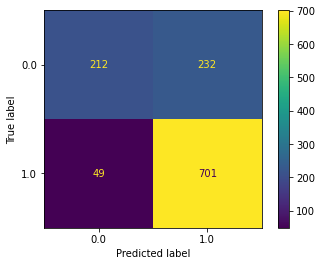

In [62]:
cb=cb.CatBoostClassifier()

Training(cb)

### LightGBM

Train F1_Score : 0.9969418960244648
Test F1_Score : 0.8323281061519905
Precision : 0.7599118942731278
Recall : 0.92
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002334D6612B0>


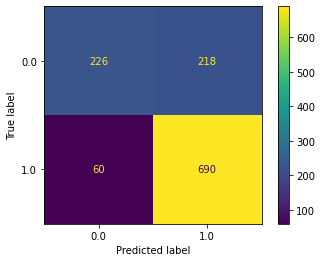

In [63]:
lgm=lgbm.LGBMClassifier(objective="binary",class_weight={0:1.5,1:1})

Training(lgm)

In [64]:
Model_Summary

,Model,Train_F1_Score,Test_F1_Score,Precision,Recall
0,LogisticRegression(class_weight='balance'),0.895422,0.828571,0.748387,0.928000
1,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.831541,0.753247,0.928000
2,"(DecisionTreeClassifier(max_depth=1, random_st...",0.906780,0.835231,0.758433,0.929333
3,KNeighborsClassifier(),0.917057,0.824529,0.756968,0.905333
4,"SVC(class_weight={0: 1.5, 1: 0.8})",0.908066,0.842500,0.792941,0.898667
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.997825,0.833234,0.750802,0.936000
6,GaussianNB(),0.877239,0.826733,0.771363,0.890667
7,<catboost.core.CatBoostClassifier object at 0x...,0.971722,0.833036,0.751340,0.934667
8,"LGBMClassifier(class_weight={0: 1.5, 1: 1}, ob...",0.996942,0.832328,0.759912,0.920000


### Observation

1. LogisticRegression provide higher recall value but low precision
2. Randomforest,Xgboost,Lightgbm provide higher train score and low test score it indicate overfitting model
3. Support vector machine very less different between train and test score with higer Precision and Recall

### HyperParameter Tuning for Randomforest, LightGBM and Supportvector Machine

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Train F1_Score : 0.9648732770120053
Test F1_Score : 0.8436541998773758
Precision : 0.7809307604994324
Recall : 0.9173333333333333
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002334D5C1100>


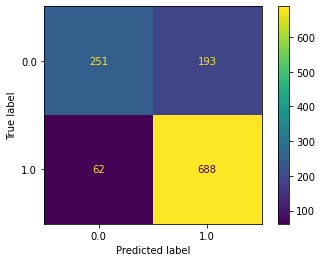

In [65]:
rf=RandomForestClassifier(random_state = 42,class_weight={0:2,1:1})
pip=make_pipeline(CT,sc,rf)

random_grid = {'randomforestclassifier__n_estimators':[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'randomforestclassifier__max_features': ['auto', 'sqrt'],
               'randomforestclassifier__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__min_samples_leaf':[ 1, 2, 4],
               'randomforestclassifier__bootstrap': [True, False]}
rs=RandomizedSearchCV(estimator = pip, param_distributions = random_grid,scoring='precision', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rs.fit(x_train,y_train)

y_pre=rs.predict(x_test)
Train_F1_Score=f1_score(y_train, rs.predict(x_train))
Test_F1_Score=f1_score(y_test, y_pre)
Precision = precision_score(y_test, y_pre)
Recall=recall_score(y_test,y_pre)

print(f"Train F1_Score : {Train_F1_Score}")
print(f"Test F1_Score : {Test_F1_Score}")
print(f"Precision : {Precision}")
print(f"Recall : {Recall}")
print(f" consufion matrix : {plot_confusion_matrix(rs,x_test,y_test)}")


Model_Summary=Model_Summary.append({"Model":"RF_hiperparameter","Train_F1_Score":Train_F1_Score,"Test_F1_Score":Test_F1_Score,
                                    "Precision":Precision, "Recall":Recall},ignore_index=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
Train F1_Score : 0.8835978835978835
Test F1_Score : 0.8356579745300182
Precision : 0.7664071190211346
Recall : 0.9186666666666666
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000023348899B20>


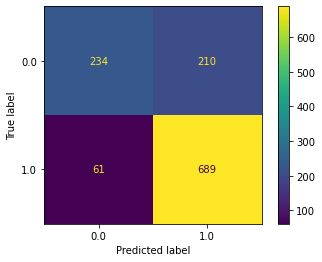

In [66]:
param_grid = {
        "lgbmclassifier__n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        "lgbmclassifier__learning_rate": [ 0.01,0.02,0.1,0.2 ,0.3],
        "lgbmclassifier__num_leaves":[int(x) for x in np.linspace(start = 20, stop = 3000, num = 10)],
        "lgbmclassifier__max_depth":[int(x) for x in np.linspace(10, 110, num = 11)],
        "lgbmclassifier__min_data_in_leaf": [2, 5, 10],
        "lgbmclassifier__lambda_l1": [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
        "lgbmclassifier__lambda_l2": [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
    }
model = lgbm.LGBMClassifier(objective="binary",class_weight={0:1.5,1:1})
pip=make_pipeline(CT,sc,model)
rs_lgbm=RandomizedSearchCV(estimator = pip, param_distributions = param_grid,scoring='precision', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rs_lgbm.fit(x_train,y_train)


y_pre=rs_lgbm.predict(x_test)
Train_F1_Score=f1_score(y_train, rs_lgbm.predict(x_train))
Test_F1_Score=f1_score(y_test, y_pre)
Precision = precision_score(y_test, y_pre)
Recall=recall_score(y_test,y_pre)

print(f"Train F1_Score : {Train_F1_Score}")
print(f"Test F1_Score : {Test_F1_Score}")
print(f"Precision : {Precision}")
print(f"Recall : {Recall}")
print(f" consufion matrix : {plot_confusion_matrix(rs_lgbm,x_test,y_test)}")


Model_Summary=Model_Summary.append({"Model":"lightGBM_hiperparameter","Train_F1_Score":Train_F1_Score,"Test_F1_Score":Test_F1_Score,
                                    "Precision":Precision, "Recall":Recall},ignore_index=True)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Train F1_Score : 0.8922808547754034
Test F1_Score : 0.8392745465916198
Precision : 0.790341578327444
Recall : 0.8946666666666667
 consufion matrix : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002334D6557C0>


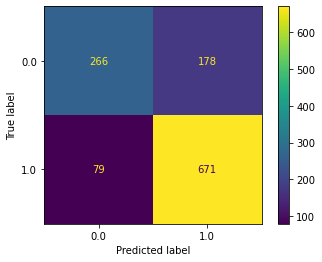

In [67]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['rbf']}

svc=SVC(class_weight={0:1.5,1:0.8},probability=True)
pip=make_pipeline(CT,sc,svc)
rs_svc=RandomizedSearchCV(estimator = pip, param_distributions = param_grid,scoring='precision', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rs_svc.fit(x_train,y_train)


y_pre=rs_svc.predict(x_test)
Train_F1_Score=f1_score(y_train, rs_svc.predict(x_train))
Test_F1_Score=f1_score(y_test, y_pre)
Precision = precision_score(y_test, y_pre)
Recall=recall_score(y_test,y_pre)

print(f"Train F1_Score : {Train_F1_Score}")
print(f"Test F1_Score : {Test_F1_Score}")
print(f"Precision : {Precision}")
print(f"Recall : {Recall}")
print(f" consufion matrix : {plot_confusion_matrix(rs_svc,x_test,y_test)}")


Model_Summary=Model_Summary.append({"Model":"svc_hiperparameter","Train_F1_Score":Train_F1_Score,"Test_F1_Score":Test_F1_Score,
                                    "Precision":Precision, "Recall":Recall},ignore_index=True)

In [68]:
Model_Summary

,Model,Train_F1_Score,Test_F1_Score,Precision,Recall
0,LogisticRegression(class_weight='balance'),0.895422,0.828571,0.748387,0.928000
1,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.831541,0.753247,0.928000
2,"(DecisionTreeClassifier(max_depth=1, random_st...",0.906780,0.835231,0.758433,0.929333
3,KNeighborsClassifier(),0.917057,0.824529,0.756968,0.905333
4,"SVC(class_weight={0: 1.5, 1: 0.8})",0.908066,0.842500,0.792941,0.898667
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.997825,0.833234,0.750802,0.936000
6,GaussianNB(),0.877239,0.826733,0.771363,0.890667
7,<catboost.core.CatBoostClassifier object at 0x...,0.971722,0.833036,0.751340,0.934667
8,"LGBMClassifier(class_weight={0: 1.5, 1: 1}, ob...",0.996942,0.832328,0.759912,0.920000
9,RF_hiperparameter,0.964873,0.843654,0.780931,0.917333


### Final Observation

1. Randomforest and Lightgbm more generalise after hiperparameter tuning
2. Support vector machine is best model after parameter variance is reduce in train and test, also Precision and recall is increase


Select final modle as <b> SVC </b> with best hiperparaeter

In [69]:
#Saving Best Model

joblib.dump(rs_svc,"Employee_attrition.joblib")

['Employee_attrition.joblib']

In [70]:
## Import Dump mode and predction

Svc=joblib.load("Employee_attrition.joblib")

Svc.predict(x_test)

array([1., 0., 1., ..., 1., 0., 1.])

In [71]:
x_train

,Gender,City,Age,Salary,Designation,Employee_Vintage,Last_3_M_Rating,week
0,Male,C23,28,57387,1,2,2,52
1,Male,C13,43,65603,2,12,1,49
2,Male,C9,29,46368,1,1,1,1
3,Male,C23,35,28116,1,5,1,26
4,Male,C19,29,119227,4,67,1,22
...,...,...,...,...,...,...,...,...
1551,Female,C27,27,54397,2,2,1,1
1552,Male,C19,26,29582,1,3,1,20
1553,Male,C24,33,82815,3,62,3,42
1554,Male,C19,44,35370,2,13,1,31
